# IIIT Bangalore - Upgrad
## Neural Networks Project - Gesture Recongition
### By : 
###    V. Sidharth Narain,
###    Megha Sharma Gavicharla,
###    Aswinikumar Panigrahi    

In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [1]:
# Importing the required libraries 

import numpy as np
import os
import datetime
import random as rn
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(30)
rn.seed(30)
np.random.seed(30)
#We set the random seed so that the results don't vary drastically.

We set the random seed so that the results don't vary drastically.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity.

In [2]:
# Path for train and validation data

train_doc = np.random.permutation(open('/Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/val.csv').readlines())
batch_size = 30

# Generator
This can be consifered as one of the most important part of the project. The overall structure of the generator has been given here. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [3]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,16,80,80,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # We are only cropping images that are too wide and converting them into 120 * 120 before resizing them to 80*80
                    if image.shape[1]==160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    else:
                        image = imresize(image,(80,80)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) * 100 / np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) * 100 / np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) * 100 / np.std(image[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        
        remaining_batches = len(t)%batch_size
        if (remaining_batches) != 0:
            batch_data = np.zeros((remaining_batches,16,80,80,3))
            batch_labels = np.zeros((remaining_batches,5))
            for folder in range(remaining_batches):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # We are only cropping images that are too wide and converting them into 120 * 120 before resizing them to 80*80
                    if image.shape[1]==160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    else:
                        image = imresize(image,(80,80)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0])) * 100 / np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1])) * 100 / np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2])) * 100 / np.std(image[:,:,2])

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/train'
val_path = '/Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


### Plotting Function

In [5]:
# Defining a function to plot the model history
# Using a Line chart to plot the scores

def plot(history, num_epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model
Here we make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model.The last layer is the softmax to get the Output.We have to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory.

In [6]:
# Importing Tensorflow.Keras Libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
Using `.fit` instead of `.fit_generator` as it supports for generators also.

In [7]:
# Train and Validation Generators

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [8]:
# Callbacks 

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [LR]
callbacks_list2 = [checkpoint]

The `steps_per_epoch` and `validation_steps` are used by `fit` to decide the number of next() calls it need to make.

In [9]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Model 1: Without Normalization and Dropouts

**Using this to determine the right hyperparameters to use**

In [10]:
# model1 = Sequential()
# model1.add(Conv3D(64,kernel_size=(3,3,3),activation='relu',input_shape=(16,80,80,3),padding='same',data_format='channels_last'))
# model1.add(MaxPooling3D(pool_size=(2,2,1),strides=(2,2,1)))
# model1.add(Conv3D(128,(3,3,3),activation='relu', padding='same'))
# model1.add(MaxPooling3D(pool_size=(2,2,1),strides=(2,2,1)))
# model1.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
# model1.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
# model1.add(MaxPooling3D(pool_size=(2,2,1),strides=(2, 2, 2)))
# model1.add(Flatten())
# model1.add(Dense(128,activation='relu'))
# model1.add(Dense(64,activation='relu'))
# model1.add(Dense(5,activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# adam = Adam(learning_rate=0.01)
# model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 80, 80, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 40, 80, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 40, 80, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 20, 80, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 20, 80, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 4, 20, 80, 256) │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 10, 40, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,104,389 (111.02 MB)

 Trainable params: 29,104,389 (111.02 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/train ; batch size = 16
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - categorical_accuracy: 0.1903 - loss: 608980.7500 Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/val ; batch size = 16
42/42 ━━━━━━━━━━━━━━━━━━━━ 722s 17s/step - categorical_accuracy: 0.1903 - loss: 599133.0000 - val_categorical_accuracy: 0.2300 - val_loss: 1.6078 - learning_rate: 0.0100
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 718s 17s/step - categorical_accuracy: 0.2170 - loss: 1.6787 - val_categorical_accuracy: 0.1800 - val_loss: 1.6084 - learning_rate: 0.0100
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - categorical_accuracy: 0.1662 - loss: 1.6102 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
42/42 ━━━━━━━━━━━━━━━━━━━━ 727s 17s/step - categorical_accuracy: 0.1666 - loss: 1.6102 - val_categorical_accuracy: 0.1800 - val_loss: 1.6103 - learning_rate: 0.0100
Epoch 4/5

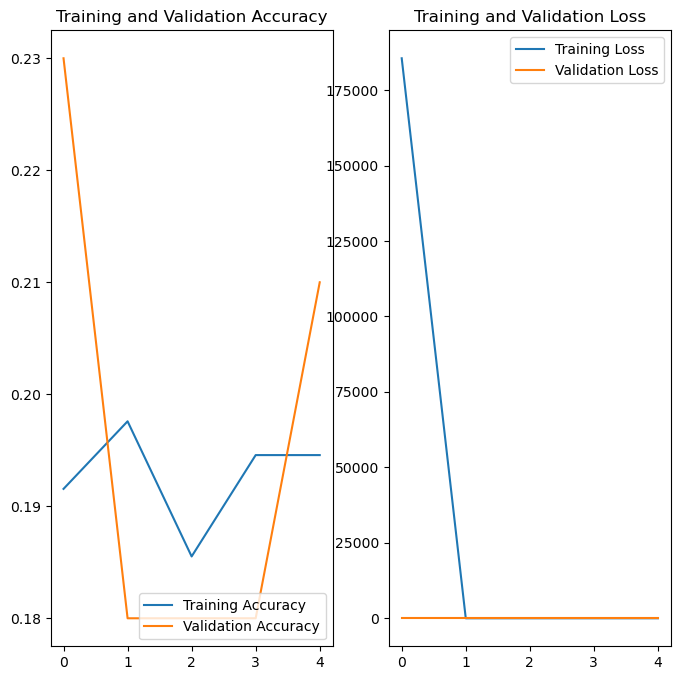

In [14]:
# plot(history1, 5)

### Model 2: Using Batch Normalization and adding Dropouts to the Model 

In [16]:
#model1.save('/Users/sidharthnarain/Documents/Upgrad_Downloads/model1.h5')

In [ ]:
# # Recreate the exact same model, including its weights and the optimizer
# load_model = tf.keras.models.load_model('final_model.h5')

# # Show the model architecture
# load_model.summary()


In [11]:
# model2 = Sequential()
# model2.add(Conv3D(64,kernel_size=(3,3,3),activation='relu',input_shape=(16,80,80,3), 
#                  padding='same',data_format='channels_last'))
# model2.add(BatchNormalization())
# model2.add(MaxPooling3D(pool_size=(2,2,1)))
# model2.add(Conv3D(128,(3,3,3),activation='relu',padding='same'))
# model2.add(BatchNormalization())
# model2.add(MaxPooling3D(pool_size=(2,2,1)))
# model2.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
# model2.add(BatchNormalization())
# model2.add(Conv3D(256,(3,3,3),activation='relu',padding='same'))
# model2.add(BatchNormalization())
# model2.add(MaxPooling3D(pool_size=(2,2,1)))
# model2.add(Flatten())
# model2.add(Dense(128,activation='relu'))
# model2.add(Dropout(0.3))
# model2.add(Dense(5,activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# adam = Adam(learning_rate = 0.01)
# model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 80, 80, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 80, 80, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 40, 80, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 40, 80, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 40, 80, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 20, 80, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 20, 80, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 20, 80, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 4, 20, 80, 256) │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 20, 80, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 10, 80, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 409600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    52,428,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,313,669 (211.00 MB)

 Trainable params: 55,312,261 (211.00 MB)

 Non-trainable params: 1,408 (5.50 KB)

None


In [15]:
# history2 = model2.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/train ; batch size = 30
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - categorical_accuracy: 0.2427 - loss: 658.3001 Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/val ; batch size = 30
23/23 ━━━━━━━━━━━━━━━━━━━━ 843s 37s/step - categorical_accuracy: 0.2419 - loss: 648.6085 - val_categorical_accuracy: 0.2300 - val_loss: 8330.2021 - learning_rate: 0.0100
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 833s 36s/step - categorical_accuracy: 0.2215 - loss: 30.9884 - val_categorical_accuracy: 0.2200 - val_loss: 466.8640 - learning_rate: 0.0100
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 831s 36s/step - categorical_accuracy: 0.2279 - loss: 3.4965 - val_categorical_accuracy: 0.2500 - val_loss: 106.7076 - learning_rate: 0.0100
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 820s 36s/step - categorical_accuracy: 0.2272 - loss: 2.9458 - val_categorical_accuracy: 0.2500 - val_loss: 42.0592 - learning_rate:

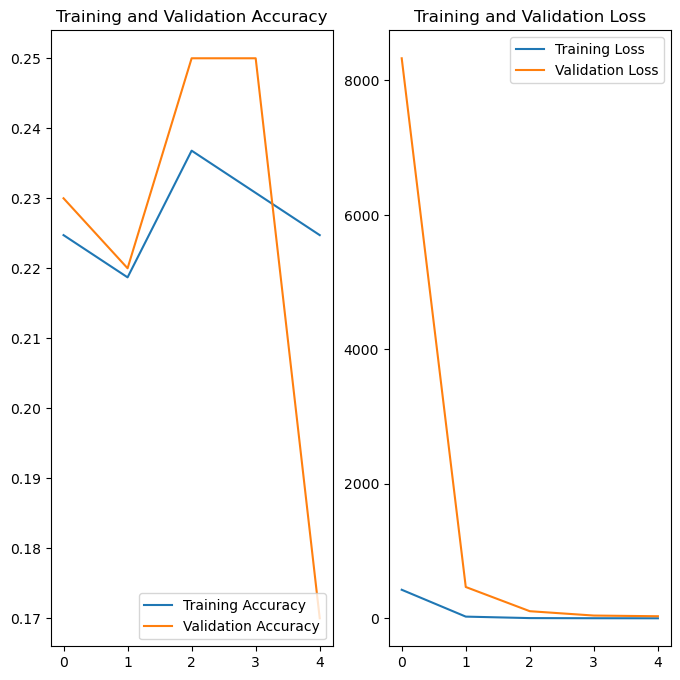

In [16]:
# plot(history2, 5)

### Model 4: A deeper model with more parameters

In [17]:
# model4 = Sequential()
# model4.add(Conv3D(32,(3,3,3),padding='same',input_shape=(16,80,80,3)))
# model4.add(BatchNormalization())
# model4.add(Activation('relu'))
# model4.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
# model4.add(Conv3D(64,(3,3,3),padding='same'))
# model4.add(BatchNormalization())
# model4.add(Activation('relu'))
# model4.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
# model4.add(Conv3D(128,(3,3,3),padding='same'))
# model4.add(BatchNormalization())
# model4.add(Activation('relu'))
# model4.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
# model4.add(Conv3D(256,(3,3,3),padding='same'))
# model4.add(BatchNormalization())
# model4.add(Activation('relu'))
# model4.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
# model4.add(Flatten())
# model4.add(Dropout(0.5))
# model4.add(Dense(128,activation='relu'))
# model4.add(Dropout(0.5))
# model4.add(Dense(5,activation='softmax'))

In [18]:
# model4.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model4.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 16, 80, 80, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 80, 80, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 80, 80, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 40, 40, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 8, 40, 40, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 40, 40, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 40, 40, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 4, 20, 20, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 4, 20, 20, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 20, 20, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 20, 20, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 2, 10, 10, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 10, 10, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 10, 10, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 10, 10, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 1, 5, 5, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,986,181 (7.58 MB)

 Trainable params: 1,985,221 (7.57 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [20]:
# history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - categorical_accuracy: 0.2125 - loss: 4.5200 - val_categorical_accuracy: 0.2400 - val_loss: 1.5833 - learning_rate: 0.0010
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - categorical_accuracy: 0.2607 - loss: 1.5884 - val_categorical_accuracy: 0.3100 - val_loss: 1.6198 - learning_rate: 0.0010
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - categorical_accuracy: 0.2129 - loss: 1.5941 - val_categorical_accuracy: 0.2500 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - categorical_accuracy: 0.2506 - loss: 1.5875 - val_categorical_accuracy: 0.2400 - val_loss: 1.6132 - learning_rate: 0.0010
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2344 - loss: 1.5972
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - categorical_accuracy: 0.2339 - loss: 1.5974 - val_categorical_accuracy: 0.2400 - val_lo

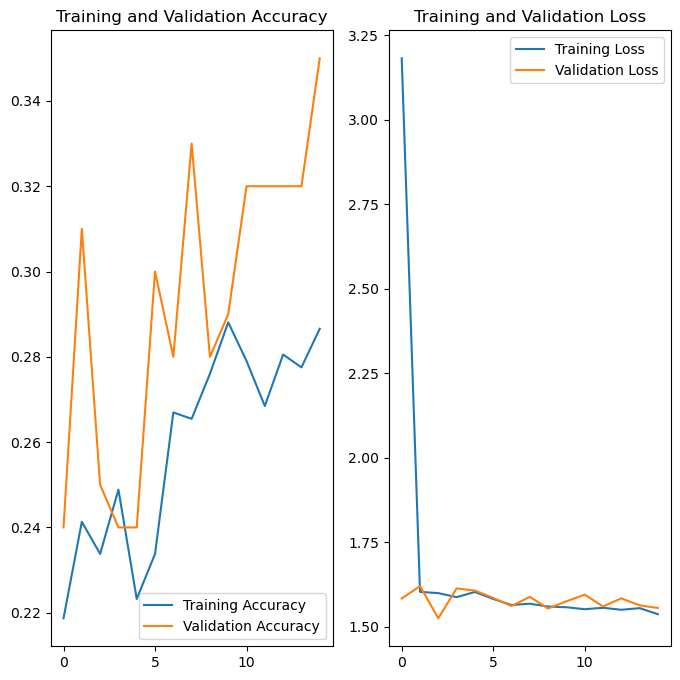

In [21]:
# plot(history4, 15)

### Model 5: Reducing Learning Rate in this Model 

In [10]:
# model5 = Sequential()
# model5.add(Conv3D(16,(3,3,3),padding='same',activation='relu',input_shape=(16,80,80,3)))
# model5.add(BatchNormalization())
# model5.add(MaxPooling3D(pool_size=(2,2,2)))
# model5.add(Conv3D(32,(3,3,3),padding='same',activation='relu'))
# model5.add(BatchNormalization())
# model5.add(MaxPooling3D(pool_size=(2,2,2)))
# model5.add(Conv3D(64,(3,3,3),padding='same',activation='relu'))
# model5.add(BatchNormalization())
# model5.add(MaxPooling3D(pool_size=(2,2,2)))
# model5.add(Conv3D(128,(3,3,3),padding='same',activation='relu'))
# model5.add(BatchNormalization())
# model5.add(MaxPooling3D(pool_size=(2,2,2)))
# model5.add(Flatten())
# model5.add(Dense(64,activation='relu'))
# model5.add(BatchNormalization())
# model5.add(Dropout(0.3))
# model5.add(Dense(64,activation='relu'))
# model5.add(BatchNormalization())
# model5.add(Dropout(0.3))
# model5.add(Dense(5,activation='softmax'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# adam = Adam(amsgrad=True, learning_rate=0.0005)
# model5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print(model5.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 80, 80, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 80, 80, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 40, 40, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 40, 40, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 40, 40, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 20, 20, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 20, 20, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 20, 20, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 10, 10, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 10, 10, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 10, 10, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 5, 5, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,661 (1.92 MB)

 Trainable params: 501,925 (1.91 MB)

 Non-trainable params: 736 (2.88 KB)

None


In [12]:
# history5 = model5.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/train ; batch size = 30
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2929 - loss: 2.0820Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/val ; batch size = 30
23/23 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - categorical_accuracy: 0.2938 - loss: 2.0785 - val_categorical_accuracy: 0.2200 - val_loss: 9.1498 - learning_rate: 5.0000e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.4663 - loss: 1.4693 - val_categorical_accuracy: 0.2200 - val_loss: 6.5719 - learning_rate: 5.0000e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.4911 - loss: 1.3298 - val_categorical_accuracy: 0.2200 - val_loss: 4.9636 - learning_rate: 5.0000e-04
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.5473 - loss: 1.1340 - val_categorical_accuracy: 0.2500 - val_loss: 2.7277 - learning_rate: 5.0000

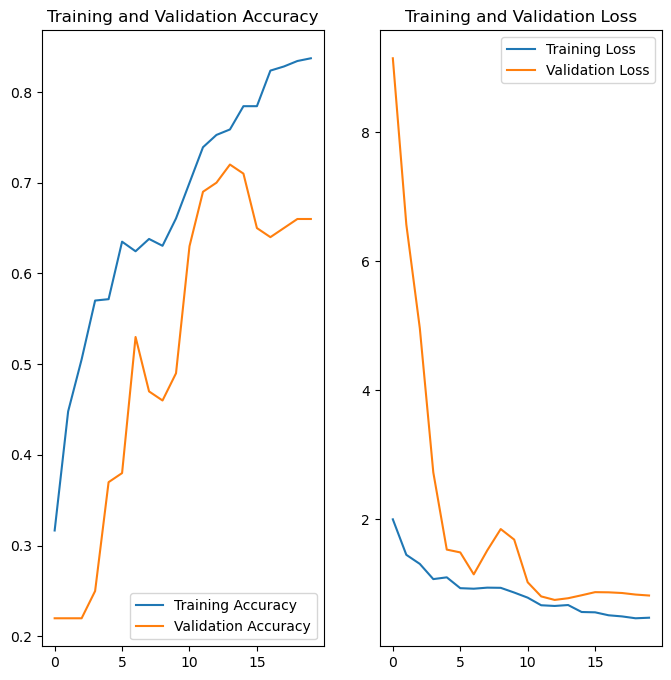

In [13]:
# plot(history5, 20)

### Model 6: CNN + RNN Simple Model

In [27]:
# model6 = Sequential()
# model6.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
#                          input_shape=(16,80,80,3)))
# model6.add(TimeDistributed(MaxPooling2D((2,2))))
# model6.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
# model6.add(TimeDistributed(MaxPooling2D((2,2))))
# model6.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
# model6.add(TimeDistributed(MaxPooling2D((2,2))))
# model6.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
# model6.add(TimeDistributed(MaxPooling2D((2,2))))
# model6.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
# model6.add(TimeDistributed(MaxPooling2D((2,2))))
# model6.add(TimeDistributed(Flatten()))
# model6.add(GRU(64))
# model6.add(Dense(64,activation='relu'))
# model6.add(Dropout(0.50))
# model6.add(Dense(5,activation='softmax'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# model6.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print(model6.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 80, 80, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 40, 40, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 40, 40, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 20, 20, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 20, 20, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 10, 10, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 10, 10,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 5, 5, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 5, 5, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 2, 2, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │       209,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,373 (2.31 MB)

 Trainable params: 606,373 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.2026 - loss: 1.8172 - val_categorical_accuracy: 0.1600 - val_loss: 1.6731 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.2231 - loss: 1.6636 - val_categorical_accuracy: 0.1900 - val_loss: 1.6051 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.2203 - loss: 1.6341 - val_categorical_accuracy: 0.2100 - val_loss: 1.6081 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2122 - loss: 1.6329
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.2130 - loss: 1.6323 - val_categorical_accuracy: 0.2300 - val_loss: 1.6068 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.2104 - loss: 1.6259 - val_categorical_accuracy: 0.2200 - val_loss: 1

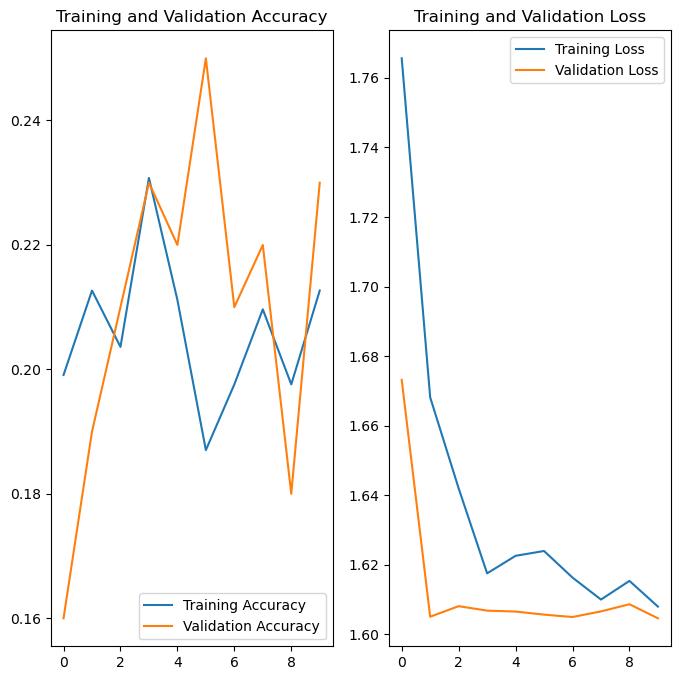

In [31]:
# plot(history6, 10)

### Model 7: CNN + GRU also adding Batch Normalization in this Model

In [32]:
# model7 = Sequential()

# model7.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
#                          input_shape=(16,80,80,3)))
# model7.add(TimeDistributed(BatchNormalization()))
# model7.add(TimeDistributed(MaxPooling2D((2,2))))
# model7.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
# model7.add(TimeDistributed(BatchNormalization()))
# model7.add(TimeDistributed(MaxPooling2D((2,2))))
# model7.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
# model7.add(TimeDistributed(MaxPooling2D((2,2))))
# model7.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
# model7.add(TimeDistributed(MaxPooling2D((2,2))))
# model7.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
# model7.add(TimeDistributed(MaxPooling2D((2,2))))
# model7.add(TimeDistributed(Flatten()))
# model7.add(GRU(64))
# model7.add(Dense(64,activation='relu'))
# model7.add(Dropout(0.50))
# model7.add(Dense(5,activation='softmax'))

In [33]:
# model7.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print(model7.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_11             │ (None, 16, 80, 80, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 80, 80, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 40, 40, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 16, 40, 40, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 16, 40, 40, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 16, 20, 20, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 16, 20, 20, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 16, 10, 10, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 16, 10, 10,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 16, 5, 5, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 16, 5, 5, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 16, 2, 2, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 16, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │       209,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,565 (2.31 MB)

 Trainable params: 606,469 (2.31 MB)

 Non-trainable params: 96 (384.00 B)

None


In [35]:
# history7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - categorical_accuracy: 0.2135 - loss: 1.7935 - val_categorical_accuracy: 0.3300 - val_loss: 1.5702 - learning_rate: 0.0010
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - categorical_accuracy: 0.2680 - loss: 1.6106 - val_categorical_accuracy: 0.1600 - val_loss: 1.6402 - learning_rate: 0.0010
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1918 - loss: 1.6677
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - categorical_accuracy: 0.1917 - loss: 1.6669 - val_categorical_accuracy: 0.1600 - val_loss: 1.6179 - learning_rate: 0.0010
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - categorical_accuracy: 0.2027 - loss: 1.6217 - val_categorical_accuracy: 0.2200 - val_loss: 1.6090 - learning_rate: 5.0000e-04
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1822 - loss: 1.6114
Epoch 5: ReduceLROnPlateau reducing learning 

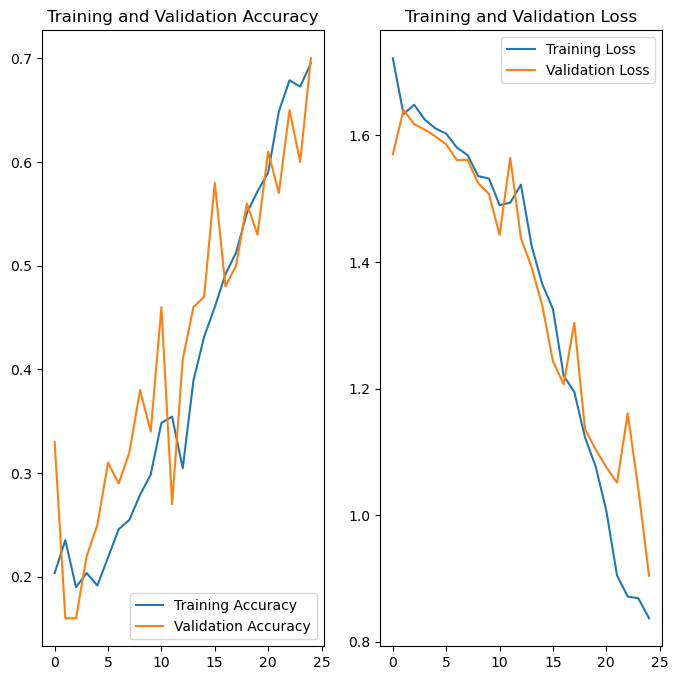

In [36]:
# plot(history7, 25)

### Model 8: CNN + LSTM(with more neurons) also using Batch Normalization in this Model

In [10]:
# model8 = Sequential()

# model8.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
#                          input_shape=(16,80,80,3)))
# model8.add(TimeDistributed(BatchNormalization()))
# model8.add(TimeDistributed(MaxPooling2D((2,2))))
# model8.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
# model8.add(TimeDistributed(BatchNormalization()))
# model8.add(TimeDistributed(MaxPooling2D((2,2))))
# model8.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
# model8.add(TimeDistributed(BatchNormalization()))
# model8.add(TimeDistributed(MaxPooling2D((2,2))))
# model8.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
# model8.add(TimeDistributed(MaxPooling2D((2,2))))
# model8.add(TimeDistributed(Conv2D(256,(3,3),padding='same',activation='relu')))
# model8.add(TimeDistributed(MaxPooling2D((2,2))))
# model8.add(TimeDistributed(Flatten()))
# model8.add(LSTM(128))
# model8.add(Dense(64,activation='relu'))
# model8.add(Dropout(0.50))
# model8.add(Dense(5,activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# model8.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print(model8.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 80, 80, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 80, 80, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 40, 40, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 40, 40, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 40, 40, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 20, 20, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 20, 20, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 20, 20, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 10, 10, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 10, 10,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 5, 5, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 16, 5, 5, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 2, 2, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           32

 Total params: 991,973 (3.78 MB)

 Trainable params: 991,749 (3.78 MB)

 Non-trainable params: 224 (896.00 B)

None


In [12]:
# history8 = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list2,validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/train ; batch size = 30
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2168 - loss: 1.6919Source path =  /Users/sidharthnarain/Documents/Upgrad_Downloads/Project_data copy/val ; batch size = 30

Epoch 1: saving model to model_init_2024-05-0317_44_16.842465/model-00001-1.66095-0.20965-1.59103-0.29000.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - categorical_accuracy: 0.2165 - loss: 1.6906 - val_categorical_accuracy: 0.2900 - val_loss: 1.5910
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2699 - loss: 1.5966
Epoch 2: saving model to model_init_2024-05-0317_44_16.842465/model-00002-1.59767-0.25641-1.57279-0.32000.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.2694 - loss: 1.5967 - val_categorical_accuracy: 0.3200 - val_loss: 1.5728
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2652 - loss: 

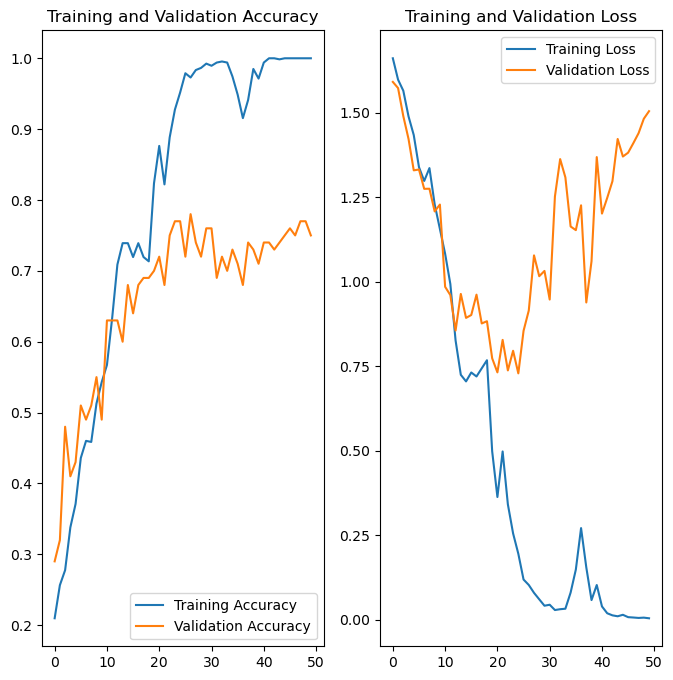

In [13]:
# plot(history8, 50)

In [14]:
# model8.save('/Users/sidharthnarain/Downloads/model-00050-0.00440-1.00000-1.50447-0.75000.weights.h5')

In [17]:
# #Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('/Users/sidharthnarain/Downloads/model-00050-0.00440-1.00000-1.50447-0.75000.weights.h5')

# #Show the model architecture
# new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 80, 80, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 80, 80, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 40, 40, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 40, 40, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 40, 40, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 20, 20, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 20, 20, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 20, 20, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 10, 10, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 10, 10,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 5, 5, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 16, 5, 5, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 2, 2, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           32

 Total params: 991,975 (3.78 MB)

 Trainable params: 991,749 (3.78 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 2 (12.00 B)

## Final Model 

**After trying the seven models above, we have decided that the Conv3D models are more robust and the adam optimizer with the amsgrad algorithm looks the better options from the model which we have tried**

In [14]:
model_final = Sequential()
model_final.add(Conv3D(16, (3,3,3), padding='same', activation='relu', input_shape=(16,80,80,3)))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_final.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_final.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_final.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling3D(pool_size=(2, 2, 2)))

# A flatten layer to convert the output to a vector 
model_final.add(Flatten())

model_final.add(Dense(64, activation='relu'))
model_final.add(BatchNormalization())

# Droupout layer for regularization
model_final.add(Dropout(0.3))

model_final.add(Dense(64, activation='relu'))
model_final.add(BatchNormalization())

# Droupout layer for regularization
model_final.add(Dropout(0.3))
# Output layer with 5 neurons
model_final.add(Dense(5, activation='softmax'))


In [15]:
adam = Adam(amsgrad=True)
model_final.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_final.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 16, 80, 80, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 80, 80, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 8, 40, 40, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 8, 40, 40, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 40, 40, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 4, 20, 20, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 4, 20, 20, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 20, 20, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 2, 10, 10, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 10, 10, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 10, 10, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 5, 5, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,661 (1.92 MB)

 Trainable params: 501,925 (1.91 MB)

 Non-trainable params: 736 (2.88 KB)

In [16]:
history_final = model_final.fit(x=train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - categorical_accuracy: 0.2500 - loss: 2.0505 - val_categorical_accuracy: 0.2600 - val_loss: 24.7426 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.4385 - loss: 1.4388 - val_categorical_accuracy: 0.3100 - val_loss: 13.9097 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.4766 - loss: 1.3480 - val_categorical_accuracy: 0.3000 - val_loss: 4.9304 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.5489 - loss: 1.1071 - val_categorical_accuracy: 0.3400 - val_loss: 3.9499 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.5916 - loss: 1.0097 - val_categorical_accuracy: 0.4500 - val_loss: 1.7678 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.6619 - loss: 0.8652 - val_categorical_accuracy: 0.42

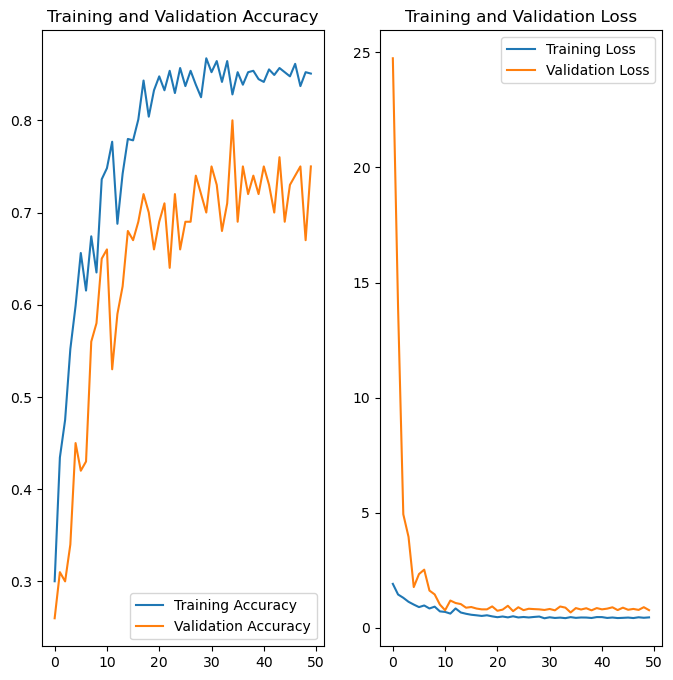

In [17]:
# Plot

plot(history_final, 50)

### Of all the models which we have trained so far, this seems to be the most robust and best fitting one. We shall use this mode as our final model

In [18]:
# To extract the .h5 file

model_final.save('/Users/sidharthnarain/Downloads/final_model.h5')

In [21]:
# Recreate the exact same model, including its weights and the optimizer

load_model = tf.keras.models.load_model('final_model.h5')

# Display the model architecture
load_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 16, 80, 80, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 80, 80, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 8, 40, 40, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 8, 40, 40, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 40, 40, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 4, 20, 20, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 4, 20, 20, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 20, 20, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 2, 10, 10, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 2, 10, 10, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 10, 10, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 1, 5, 5, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,663 (1.92 MB)

 Trainable params: 501,925 (1.91 MB)

 Non-trainable params: 736 (2.88 KB)

 Optimizer params: 2 (12.00 B)

In [20]:
#Evaluate the final model

load_model.evaluate(val_generator,steps=validation_steps)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - categorical_accuracy: 0.7928 - loss: 0.6991 


[0.7527413964271545, 0.7599999904632568]

# Final Model Accuracy - 79.2%